In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import xarray as xr
from pathlib import Path

### Setup

In [26]:
pwd = Path("/N/u/ckieu/Quartz/model/da_letkf_swe/").resolve()
ana_path = pwd /"fsc" / "00:00:00"
ctl_path = pwd / "ctl"
tru_path = pwd / "truth"
lats = np.arange(17)
lons = np.arange(114)
nt = 41
dt = 3
times = np.arange(0, nt) * dt

### Util Functions

In [11]:
def read_data(fname, width=13, dims=(17,114)):
    raw = np.genfromtxt(fname, dtype=None, delimiter=width).flatten()
    data = raw.reshape(3, *dims)[-1]
    return data

### Read ctl

In [12]:
arrs = []
for i, fname in enumerate(sorted(ctl_path.glob("ctl_*.dat"))):
    tstep = read_data(fname)
    arrs.append(tstep)

ctl = np.array(arrs)
print(f"Loaded ctl data w/ shape: {ctl.shape}")

Loaded ctl data w/ shape: (41, 17, 114)


### Read tru

In [13]:
arrs = []
for i, fname in enumerate(sorted(tru_path.glob("tru_*.dat"))):
    tstep = read_data(fname)
    arrs.append(tstep)

tru = np.array(arrs)
print(f"Loaded tru data w/ shape: {tru.shape}")

Loaded tru data w/ shape: (41, 17, 114)


### Read fsc

In [27]:
ensd = {f"{i:03}": [] for i in range(1, 31)}
for i, fname in enumerate(sorted(ana_path.rglob("fsc_*.dat"))):
    mem_id = fname.parent.name.split("_")[1] #mem_001
    assert mem_id in ensd.keys(), "key not found"
    tstep = read_data(fname)
    ensd[mem_id].append(tstep)

ens_arrs = []
for k, v in sorted(ensd.items(), key=lambda k: int(k[0])):
    ens_arrs.append(v)

ens = np.array(ens_arrs)
n_ens = ens.shape[0]
ens_mean = ens.mean(axis=0)

In [28]:
ens.shape

(30, 41, 17, 114)

### Find z_mins


In [33]:
zmin = lambda x: x[:, :11].min(axis=(1,2))
ctl_zmin = zmin(ctl)
tru_zmin = zmin(tru)
ens_zmin = ens[:, :, :11].min(axis=(2,3))
ens_mean_zmin = ens_zmin.mean(axis=0)


In [32]:
ens_zmin.shape

(30, 41)

### Plot data

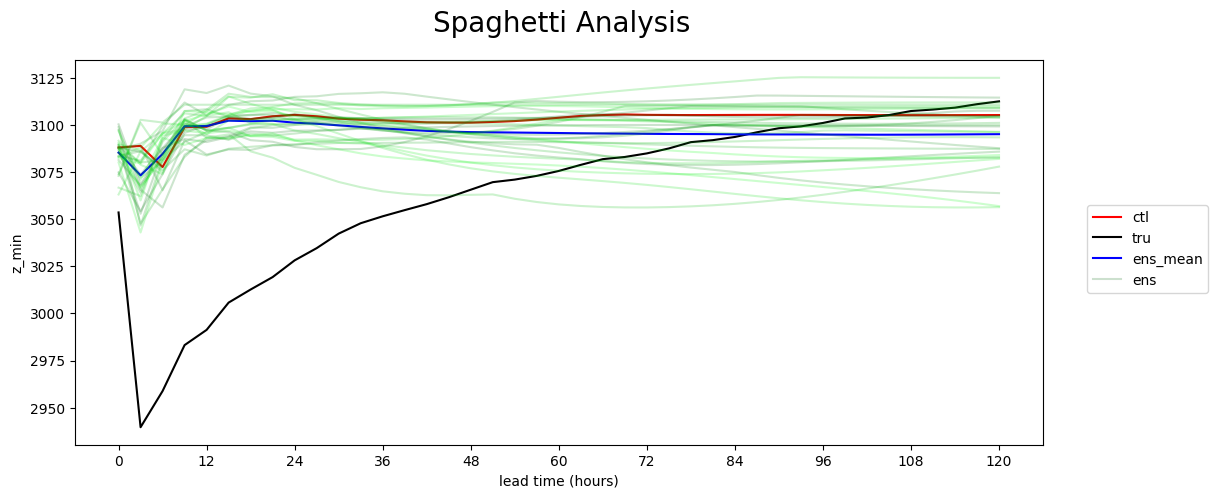

In [34]:
styles = {
    "ctl": {"c":"red", "label": "ctl"},
    "tru": {"c": "black", "label": "tru"},
    "ens_mean": {"c": "blue", "label": "ens_mean"},
    "ens": [{"c": (0, x / 255, 10 / 255, 0.2)} for x in np.linspace(100, 255, n_ens).astype("int")]
}

xticks = times[::4]
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(times, ctl_zmin, **styles["ctl"])
ax.plot(times, tru_zmin, **styles["tru"])
ax.plot(times, ens_mean_zmin, **styles["ens_mean"])
for i, sty in enumerate(styles["ens"]):
    if i == 0:
        ax.plot(times, ens_zmin[i], **sty, label="ens")

    else:
        ax.plot(times, ens_zmin[i], **sty)

ax.set_xticks(xticks)
ax.set_xlabel("lead time (hours)")
ax.set_ylabel("z_min")
fig.suptitle("Spaghetti Analysis", fontsize=20)
fig.legend(loc="center right")
fig.subplots_adjust(right=0.87)

plt.show()
